## Recommendation System for Neflix
Name: Stan Assendelft
<br> Studentnumber: 500748446
<br> Course: System Development for Marketing

# 1| Introduction
Recommender systems or recommendation systems are a subclass of informaton filtering system that seek to predict 'rating'or 'preference' that a user would give to an item or social element they had not yet considered, using a model built form the characteristics of an item (L. Sharma & A. Gera, 2013). In this case the items are movies from the online platform Netflix.

Research Question:<br> 
How can recommender systems be used to give better movie recommendations for the users on a movie streaming platform?

Sub-questions:<br>
1) How are movies, users, and ratings distributed within the dataset?
2) What are the different approaches used in movie recommendation systems?
3) Which machine learning methods can identify patterns in user preferences and generate recommendations?
4) How can we evaluate the predictive accuracy of KNN and SVD models?

# 2| Dataset Preparation

### 2.1| Load the libraries

In [151]:
# Importing all the needed libraries 
import zipfile
import os
import pandas as pd
import numpy as np
from collections import defaultdict

# Importing libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importing sklearn for calculations 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Importing scipy for calculations
from scipy.sparse import csr_matrix

# Importing surprise for Singular Value Decomposition (SVD) and K-Nearest Neighbors (KNN)
from surprise import KNNBasic, SVD, Reader, Dataset
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

### 2.2| Load the dataset

For demonstrating purposes, the dataset includes not all the users, making it more manageable for inital exploration.

In [75]:
# Unzipping the training_set file
zip_path = 'training_set.zip'
extract_to = os.path.dirname(zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

The next step is to read the data after unzipping the training_set file

In [76]:
folder_path = 'training_set'
data_frames = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Open the file and read lines
        with open(file_path, 'r') as file:
            lines = file.readlines()
            movie_id = lines[0].strip().replace(':', '')  # Extract the movie ID and remove the colon

            # Collect data from each line except the first into a list of dicts
            data = []
            for line in lines[1:]:
                user, rating, date = line.strip().split(',')
                data.append({'movie': movie_id, 'user': user, 'rating': int(rating), 'date': date})

            # Convert list of dicts to DataFrame and add to list
            data_frames.append(pd.DataFrame(data))

# Putting all DataFrame pieces into one DataFrame
df = pd.concat(data_frames, ignore_index=True)
df.date = pd.to_datetime(df.date)
df.to_csv('Moviedataupdated.csv',header = False)

# Display the DataFrame
df

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


Now we will filter the dataset to include only 1000 unique users, ensuring that the data is structured and manageable fo analysis. This step reduces the dataset size while maintaining diversity, making it easier to train and evaluate the model.

In [77]:
# Ensure the 'user' column is of numeric type
df['user'] = pd.to_numeric(df['user'], errors='coerce')

# Drop any rows where 'user' could not be converted (if applicable)
df = df.dropna(subset=['user'])

# Convert 'user' column to integer (after coercion)
df['user'] = df['user'].astype(int)

# Select a subset of 1000 unique users
selected_users = df['user'].unique()[:1000]  # Taking the first 1000 unique users

# Filter DataFrame for only those users
df = df[df['user'].isin(selected_users)]

# Sort the DataFrame by the 'user' column
df = df.sort_values(by='user')

# Reset index after filtering
df = df.reset_index(drop=True)

# Display the filtered dataset
df

,movie,user,rating,date
0,13293,915,4,2005-02-02
1,11265,915,5,2005-06-27
2,9645,915,4,2005-06-27
3,6859,915,3,2005-06-27
4,694,915,5,2005-08-17
...,...,...,...,...
914408,11931,2648861,3,2004-04-23
914409,14858,2648861,4,2003-11-07
914410,3756,2648861,4,2003-07-10
914411,30,2648861,3,2005-03-29


### 2.3| Checking the data

In [78]:
df.date = pd.to_datetime(df.date)

df.to_csv('Moviedataupdated.csv',header = False)
df

,movie,user,rating,date
0,13293,915,4,2005-02-02
1,11265,915,5,2005-06-27
2,9645,915,4,2005-06-27
3,6859,915,3,2005-06-27
4,694,915,5,2005-08-17
...,...,...,...,...
914408,11931,2648861,3,2004-04-23
914409,14858,2648861,4,2003-11-07
914410,3756,2648861,4,2003-07-10
914411,30,2648861,3,2005-03-29


In [79]:
df.describe()['rating']

count    914413.000000
mean          3.126443
std           1.281915
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [80]:
print("Total data ")
print("\nTotal ratings :",df.shape[0])
print("Total users   :", len(np.unique(df.user)))
print("Total movies  :", len(np.unique(df.movie)))

Total data 

Total ratings : 914413
Total users   : 1000
Total movies  : 17759


The dataset contains 914,413 rows, meaning there are over 900,000 user-movie interactions. Each user has rated one or multiple movies. The 1000 users in this dataset has rated 17,759 movies. The 914,413 ratings vary from 1 to 5. Where a 5 is the highest rating that can be given. 

In [81]:
# Checking for nulls and duplicates
print("Number of Nan values in the DataFrame:", sum(df.isnull().any()))
dup_bool = df.duplicated(['movie', 'user', 'rating'])
dups = sum(dup_bool)
print("Number of dupliceted rating entries in the DataFrame: {}".format(dups))

Number of Nan values in the DataFrame: 0
Number of dupliceted rating entries in the DataFrame: 0


The CSV file containing all movie titles will be loaded, allowing us to map each movie ID to its corresponding title for better interpretation and analysis.

In [82]:
file_path = 'movie_titles.csv'
movie_titles_df = pd.read_csv(file_path, header=None, names=['movie', 'release_year', 'movie_name'], encoding='ISO-8859-1', on_bad_lines='skip')

# Display the first few rows of the dataframe
movie_titles_df= movie_titles_df.head(100)
movie_titles_df

,movie,release_year,movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
95,97,2002.0,Mostly Martha
96,98,1965.0,The Battle of Algiers: Bonus Material
97,99,1989.0,A Fishy Story
98,100,1993.0,Sam the Iron Bridge


In [83]:
# Saving the dataframe to a new CSV file
movie_titles_df.to_csv("movie_titles_updated.csv", index=False)

The following step combines all the ratings with the movie titles.

In [84]:
# Ensuring 'movie' column in both DataFrames is of type int
df['movie'] = pd.to_numeric(df['movie'], errors='coerce')
movie_titles_df['movie'] = pd.to_numeric(movie_titles_df['movie'], errors='coerce')

# Droping any rows where 'movie' could not be converted
df = df.dropna(subset=['movie'])
movie_titles_df = movie_titles_df.dropna(subset=['movie'])

# Convert 'movie' to integer
df['movie'] = df['movie'].astype(int)
movie_titles_df['movie'] = movie_titles_df['movie'].astype(int)

# Merge
combined_data = pd.merge(df, movie_titles_df, on='movie', how='inner')

# Display
combined_data

,movie,user,rating,date,release_year,movie_name
0,1,915,5,2005-08-17,2003.0,Dinosaur Planet
1,1,2442,3,2004-04-14,2003.0,Dinosaur Planet
2,1,3321,3,2005-09-27,2003.0,Dinosaur Planet
3,1,4326,4,2005-10-29,2003.0,Dinosaur Planet
4,1,11589,3,2005-10-19,2003.0,Dinosaur Planet
...,...,...,...,...,...,...
4946,98,1947922,5,2004-12-03,1965.0,The Battle of Algiers: Bonus Material
4947,98,2494367,5,2005-10-03,1965.0,The Battle of Algiers: Bonus Material
4948,13,667730,5,2005-05-30,2003.0,Lord of the Rings: The Return of the King: Ext...
4949,13,685113,5,2005-11-23,2003.0,Lord of the Rings: The Return of the King: Ext...


Instead of just working with movie ID's, we now have actual movie names and release years.

In [85]:
print(combined_data['user'].value_counts().head(10))

387418     97
305344     96
2439493    94
1664010    88
2118461    78
1461435    58
2056022    48
2606799    40
507603     37
752642     36
Name: user, dtype: int64


The top 10 users who have rated the most movies in the dataset. The output shows the user IDs along with the number of ratings they provided.



# 3| Exploratory Data Analysis

In this section, we go through the Exploratory Data Analysis. This will help understanding the data. 

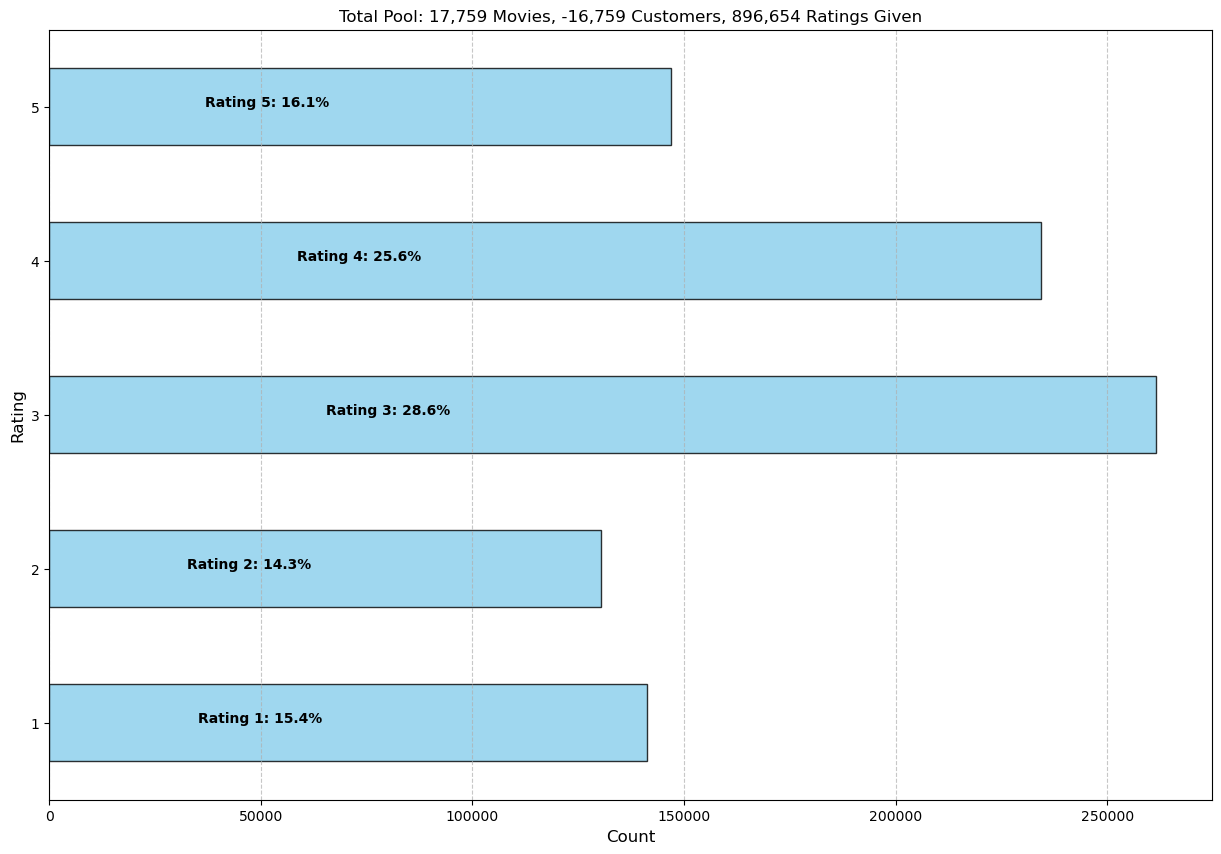

In [86]:
# Group ratings and count occurrences
rating_counts = df.groupby('rating')['rating'].count()

# Get unique counts
movie_count = df['movie'].nunique()
cust_count = df['user'].nunique() - movie_count
rating_count = df['user'].count() - movie_count

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
rating_counts.plot(kind='barh', color='skyblue', edgecolor='black', alpha=0.8, ax=ax)

# Title and formatting
plt.title(f"Total Pool: {movie_count:,} Movies, {cust_count:,} Customers, {rating_count:,} Ratings Given")
plt.xlabel('Count', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages
total_ratings = rating_counts.sum()
for i, (count, rating) in enumerate(zip(rating_counts.values, rating_counts.index)):
    ax.text(count / 4, i, f'Rating {rating}: {count * 100 / total_ratings:.1f}%', color='black', weight='bold')

plt.show()


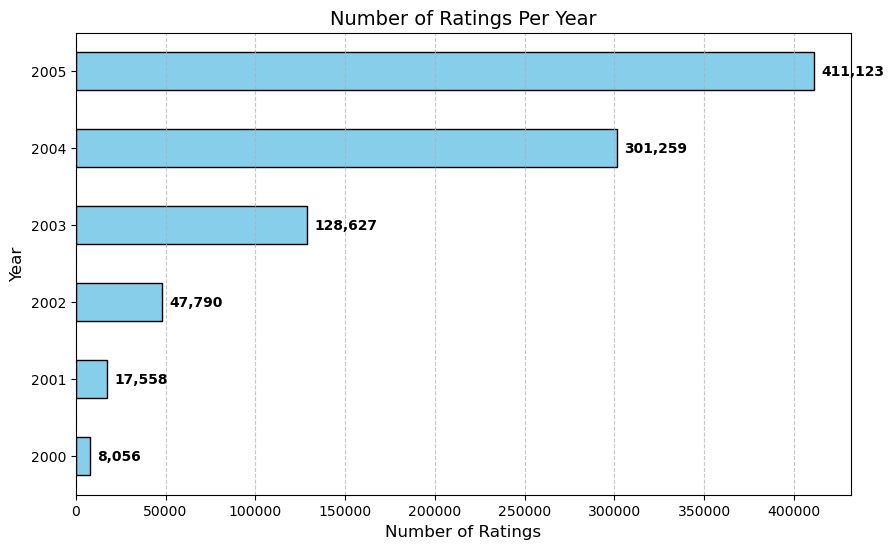

In [87]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Count the number of ratings per year
ratings_per_year = df['year'].value_counts().sort_index()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
ax = ratings_per_year.plot(kind='barh', color='skyblue', edgecolor='black')

# Add labels near the bars
for index, value in enumerate(ratings_per_year):
    plt.text(value + (max(ratings_per_year) * 0.01), index, f'{value:,}', va='center', fontsize=10, fontweight='bold', color='black')

# Titles and labels
plt.title('Number of Ratings Per Year', fontsize=14)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

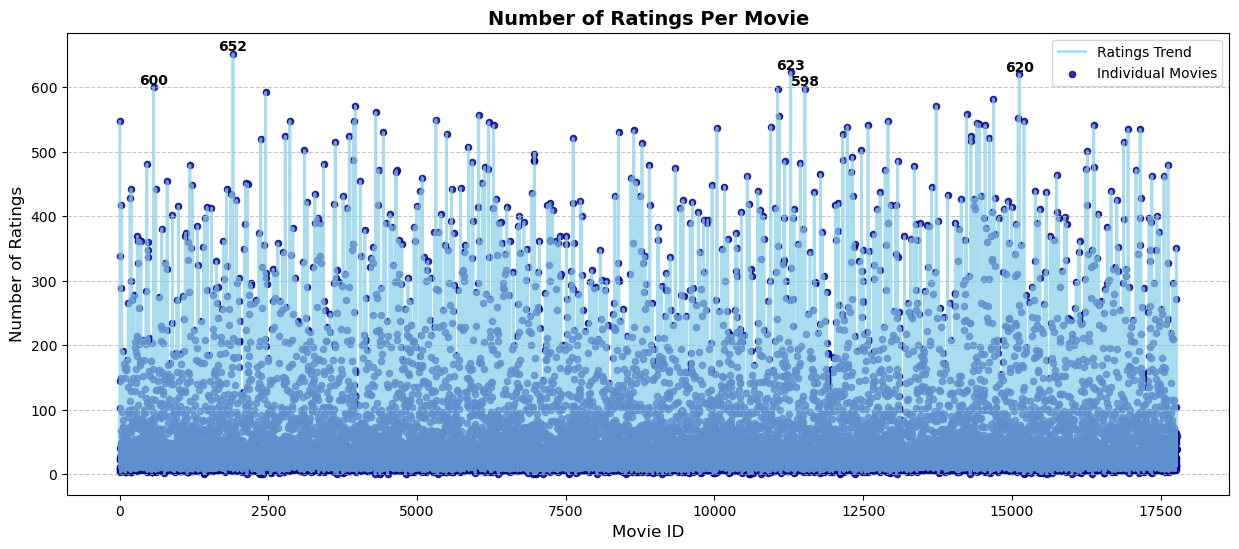

In [88]:
# Count the number of ratings per movie
ratings_per_movie = df['movie'].value_counts().sort_index()

# Create the figure
plt.figure(figsize=(15, 6))

# Line plot for overall trend
plt.plot(ratings_per_movie.index, ratings_per_movie.values, linestyle='-', color='skyblue', linewidth=2, alpha=0.7, label="Ratings Trend")

# Scatter plot to highlight individual points
plt.scatter(ratings_per_movie.index, ratings_per_movie.values, color='darkblue', alpha=0.8, s=20, label="Individual Movies")

# Annotate the top-rated movies
top_movies = ratings_per_movie.nlargest(5)
for movie_id, rating_count in zip(top_movies.index, top_movies.values):
    plt.text(movie_id, rating_count, f'{rating_count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Titles and labels
plt.title('Number of Ratings Per Movie', fontsize=14, fontweight='bold')
plt.xlabel('Movie ID', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# 4| Model Training and Evaluation

In [132]:
from sklearn.model_selection import train_test_split

# Splitting: 80% train, 20% test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
# 75% of train_data for training, 25% for validation
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
# Display split sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 548647
Validation set size: 182883
Testing set size: 182883


In [143]:
df_matrix = df.pivot_table(index='user', columns='movie', values='rating').fillna(0)

# Convert each split into user-item matrices
train_matrix = train_data.pivot(index="user", columns="movie", values="rating").fillna(0)
sparse_train_matrix = csr_matrix(train_matrix)

val_matrix = val_data.pivot(index="user", columns="movie", values="rating").fillna(0)
sparse_val_matrix = csr_matrix(val_matrix)

test_matrix = test_data.pivot(index="user", columns="movie", values="rating").fillna(0)
sparse_test_matrix = csr_matrix(test_matrix)

In [144]:
df_matrix.head()

movie,1,2,3,4,5,6,7,8,9,10,...,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770
user,,,,,,,,,,,,,,,,,,,,,
915,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1333,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,4.0,3.0,1.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0
2442,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3321,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,3.0,0.0,2.0,0.0,0.0
4326,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.1| K-Nearest Neighbors

The rapid expansion of digital media has led to the rise of numerous streaming platforms like Netflix. These platforms offer an overwhelming number of choices for users when selecting a movie. To simplify the decision-making process, a K-Nearest Neighbors (KNN)-based recommendation system is implemented to generate personalized movie suggestions.

This model operates on a user-user similarity approach, meaning it identifies users wiht similar viewing patterns to make recommendations. It takes a user ID as input, finds users with the most similar rating behavior, and recommends the highest-rated moves among those similar users. 

By computing the similarity scores between the target user and all other users in the training set, we are able to identify the most similar users, excluding the target user themself. These top users are likely to have similar tastes, and their preferences will be used later to generate personalised recommendations.

In [ ]:
# Define parameters
# Choosing a target user from the validation set
target_user = val_matrix.index[0] 
num_neighbors = 30 

# Cosine similarity between target user and all other users
similarities = cosine_similarity(sparse_train_matrix.getrow(target_user), sparse_train_matrix).ravel()

# Find the top similar users (excluding the user itself)
top_similar_users = np.argsort(similarities)[-num_neighbors-1:-1]  # Exclude self
top_similar_values = similarities[top_similar_users]

# Store results
similar_users_df = pd.DataFrame({"User ID": top_similar_users, "Similarity Score": top_similar_values})
similar_users_df = similar_users_df.sort_values(by="Similarity Score", ascending=False)

print(f"Top {num_neighbors} similar users to User {target_user}:")
print(similar_users_df)

Top 30 similar users to User 915:
    User ID  Similarity Score
29      164          0.475675
28      650          0.457635
27      810          0.457432
26      128          0.443788
25      980          0.380139
24      792          0.378174
23       11          0.346911
22      573          0.343538
21      138          0.337251
20      817          0.332370
19      314          0.331858
18      203          0.331310
17      307          0.323083
16      284          0.322598
15      312          0.321875
14      696          0.319264
13      654          0.317179
12      227          0.312838
11      700          0.312582
10       64          0.311590
9       306          0.311339
8       553          0.307306
7        70          0.306124
6       968          0.302355
5       213          0.301010
4       268          0.297356
3       988          0.297180
2       628          0.295466
1       285          0.293334
0       253          0.292105


In [ ]:
def top_neighbours(user_id, train_matrix, k=5):
   
    # Compute similarity scores between the user and all others
    sim_scores = cosine_similarity(train_matrix.getrow(user_id), train_matrix).ravel()

    # Exclude the user itself
    sim_scores[user_id] = -1

    # Get top-k neighbors (sorted by similarity)
    top_indices = np.argsort(sim_scores)[-k:][::-1]
    top_similarities = sim_scores[top_indices]

    return list(zip(top_indices, top_similarities))


This function takes a user ID, the training matrix, and a number of nearest neighbors (k) as input. It returns the k most similar users based on cosine similarity.

Within the function, we calculate the similarity scores between the selected user and all others in the training set. We then explicitly exclude the user themself by setting their similarity score to -1, ensuring they are not mistakenly included in their own neighborhood.

After identifying the most similar users, the function below generate personalised rating predictions for a specific user. The function takes the user ID, the training user-item matrix, and the number of neighbors k as inputs. Next, for each movie that the user hasn’t rated yet, the function calculates a weighted average rating. This is done by aggregating the ratings of the user's top neighbors, weighted by their similarity scores. The higher the similarity, the more influence a neighbor has on the final prediction.

In [ ]:
def predict_ratings_for_user(user_id, train_matrix_df, k=15):
    
    # Ensure user exists in training data
    if user_id not in train_matrix_df.index:
        print(f"User {user_id} not found in training matrix.")
        return pd.DataFrame()

    # Convert DataFrame to sparse matrix for similarity
    sparse_matrix = csr_matrix(train_matrix_df.values)

    # Get top-k neighbors
    user_idx = train_matrix_df.index.get_loc(user_id)
    neighbors = get_top_neighbours(user_idx, sparse_matrix, k)

    user_ratings = train_matrix_df.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index

    predictions = []
    for movie_id in unrated_movies:
        weighted_sum = 0
        similarity_sum = 0

        for neighbor_idx, similarity in neighbors:
            neighbor_id = train_matrix_df.index[neighbor_idx]
            neighbor_rating = train_matrix_df.loc[neighbor_id, movie_id]
            if neighbor_rating > 0:
                weighted_sum += similarity * neighbor_rating
                similarity_sum += similarity

        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
            predictions.append((movie_id, predicted_rating))

    return pd.DataFrame(predictions, columns=["movie", "predicted_rating"]).sort_values(by="predicted_rating", ascending=False)

In [148]:
user_id = 2056022 
# Generate recommendations
recommendations = predict_ratings_for_user(user_id, train_matrix, k=15)

# Merge with movie titles
recommendations_with_titles = recommendations.merge(combined_data, on="movie", how="left")

# Show the top recommendations with titles
print(f"Top recommended movies for user {user_id}")
print(recommendations_with_titles[['movie', 'movie_name', 'predicted_rating']].head(40))


Top recommended movies for user 2056022
    movie        movie_name  predicted_rating
0   14720               NaN               5.0
1   10292               NaN               5.0
2   13287               NaN               5.0
3    7105               NaN               5.0
4   14658               NaN               5.0
5   10789               NaN               5.0
6   17413               NaN               5.0
7    2529               NaN               5.0
8   11124               NaN               5.0
9   11216               NaN               5.0
10   6847               NaN               5.0
11  16648               NaN               5.0
12   6800               NaN               5.0
13  14021               NaN               5.0
14   6799               NaN               5.0
15   6505               NaN               5.0
16   2249               NaN               5.0
17   4585               NaN               5.0
18  17602               NaN               5.0
19   6452               NaN             

User_id = 2056022 is selected as the target user and used the trained model to predict their ratings for all movies they hadn’t rated yet. These predictions were calculated using a weighted average of ratings from the most similar users, where the similarity score (based on cosine distance) determined the influence each neighbor had. To make the output more informative, the predictions are merged with the movie titles using the movie column. However, many movies are not displaying a title due to missing matches between predicted movie IDs and the titles dataset. This issue may com from differences in filtering or data inconsistencies introduced during preprocessing.

In [162]:
# Merge recommendations with movie titles
recommendations_with_titles = recommendations.merge(
    combined_data[["movie", "movie_name"]].drop_duplicates(),
    on="movie",
    how="left"
)

# Filter out entries without a movie name
recommendations_with_titles = recommendations_with_titles.dropna(subset=["movie_name"])

# Show top results
print(f"Top recommended movies for user {user_id}")
print(recommendations_with_titles[['movie', 'movie_name', 'predicted_rating']].head(10))


Top recommended movies for user 2056022
      movie                                         movie_name  \
16       13  Lord of the Rings: The Return of the King: Ext...   
70       81                                   Antarctica: IMAX   
88       30                             Something's Gotta Give   
258       1                                    Dinosaur Planet   
372      50                               A Yank in the R.A.F.   
925      28                                    Lilo and Stitch   
984      27  Sesame Street: Elmo's World: The Street We Liv...   
1234     96                           Inside the Space Station   
1779     77                                              Congo   
1785     25      Inspector Morse 31: Death Is Now My Neighbour   

      predicted_rating  
16            5.000000  
70            4.138161  
88            4.064373  
258           3.822602  
372           3.714477  
925           3.397196  
984           3.371787  
1234          3.290408  
1779    

To make the KNN recommendations more understandable, we merged the predicted ratings with the movie titles using the movie IDs and filterd out entries without a movie name. So that we can display the top recommended movies with their names instead of just IDs.

In [152]:
sample_users = np.random.choice(test_data["user"].unique(), size=200, replace=False)
actual_ratings = []
predicted_ratings = []

for user_id in sample_users:
    recs = predict_ratings_for_user(user_id, train_matrix, k=15)
    if recs.empty:
        continue
    
    user_test = test_data[test_data["user"] == user_id]
    merged = user_test.merge(recs, on="movie", how="inner")

    actual_ratings.extend(merged["rating"])
    predicted_ratings.extend(merged["predicted_rating"])

rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"Sampled Manual KNN RMSE: {rmse:.4f}")


Sampled Manual KNN RMSE: 1.2277


#### 4.1.1| Hyperparameter Tunning for 
Since hyperparameter tunning directly affects the model's accuracy and efficiency (Ilemobay et al., 2024), it is an essential step in optimising the K-Nearst Neightbours recommendation method. In this process we adjust key parameters to improve the quality of recommendations. 

An important key parameter is "K". This determines how many similar users are considered when making recommendations. a small "K" might lead to noisy predections, while a large number of "K" may weaken the similarity effect. 

To find the best parameter, we test different values and evaluate performance using the average distance between nearest neighbors. Lower distances indicate more similar users, improving recommendation quility. The optimal configuration mnimizes this metric, enhancing personalisation and accuracy in movie recommendations. 

In [155]:
k_values = [5, 10, 15, 20, 25, 30, 35, 40]
rmse_scores = {}
sample_users = np.random.choice(val_data["user"].unique(), size=200, replace=False)

for k in k_values:
    actual = []
    predicted = []

    for user_id in sample_users:
        recs = predict_ratings_for_user(user_id, train_matrix, k=k)
        if recs.empty:
            continue

        user_val = val_data[val_data["user"] == user_id]
        merged = user_val.merge(recs, on="movie", how="inner")

        actual.extend(merged["rating"])
        predicted.extend(merged["predicted_rating"])

    if predicted:
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        rmse_scores[k] = rmse
        print(f"k = {k} > RMSE: {rmse:.4f}")

# Pick the best k
best_k = min(rmse_scores, key=rmse_scores.get)
print(f"\ Best k value: {best_k} with RMSE: {rmse_scores[best_k]:.4f}")


k = 5 > RMSE: 1.4492
k = 10 > RMSE: 1.2921
k = 15 > RMSE: 1.2451
k = 20 > RMSE: 1.2293
k = 25 > RMSE: 1.2087
k = 30 > RMSE: 1.2002
k = 35 > RMSE: 1.1968
k = 40 > RMSE: 1.1891
\ Best k value: 40 with RMSE: 1.1891


In [157]:
# Final evaluation on test set
final_k = 40
sample_test_users = np.random.choice(test_data["user"].unique(), size=200, replace=False)

final_actual = []
final_predicted = []

for user_id in sample_test_users:
    recs = predict_ratings_for_user(user_id, train_matrix, k=final_k)
    if recs.empty:
        continue

    user_test = test_data[test_data["user"] == user_id]
    merged = user_test.merge(recs, on="movie", how="inner")

    final_actual.extend(merged["rating"])
    final_predicted.extend(merged["predicted_rating"])

# Compute final RMSE
final_rmse = np.sqrt(mean_squared_error(final_actual, final_predicted))
print(f"Final KNN Model RMSE on test data (k={final_k}): {final_rmse:.4f}")


Final KNN Model RMSE on test data (k=40): 1.2774


To enhance the accuracy of the KNN model, hyperparameter tuning was applied by testing various values of k, representing the number of nearest neighbors. RMSE scores were calculated using a validation set of 200 sampled users. The lowest RMSE of 1.2774 was achieved when k was set to 40, making it the optimal choice for this model.

#### 4.1.2| Movie recommendation based in KNN

Using the optimal value of k = 40, the final KNN model was used to generate personalised movie recommendations. After predicting ratings for unseen movies, the top 10 were selected based on the highest predicted scores.

In [ ]:
# Generate recommendations for a specific user
user_id = 2056022
recommendations = predict_ratings_for_user(user_id, train_matrix, k=best_k)

# Merge recommendations with movie titles
recommendations_with_titles = recommendations.merge(
    combined_data[["movie", "movie_name"]].drop_duplicates(),
    on="movie",
    how="left"
)

# Filter out movies without a movie name
recommendations_with_titles = recommendations_with_titles.dropna(subset=["movie_name"])

# Display the top 10 recommended movies
print(f"Top recommended movies for user {user_id}")
print(recommendations_with_titles[['movie', 'movie_name', 'predicted_rating']].head(10))


Top recommended movies for user 2056022
      movie                                         movie_name  \
16       13  Lord of the Rings: The Return of the King: Ext...   
70       81                                   Antarctica: IMAX   
88       30                             Something's Gotta Give   
258       1                                    Dinosaur Planet   
372      50                               A Yank in the R.A.F.   
925      28                                    Lilo and Stitch   
984      27  Sesame Street: Elmo's World: The Street We Liv...   
1234     96                           Inside the Space Station   
1779     77                                              Congo   
1785     25      Inspector Morse 31: Death Is Now My Neighbour   

      predicted_rating  
16            5.000000  
70            4.138161  
88            4.064373  
258           3.822602  
372           3.714477  
925           3.397196  
984           3.371787  
1234          3.290408  
1779    

### 4.2| K-Nearest Neighbors with Surprise package
In this section, the KNN is implemented using the Surprise library, which is specifically designed for building and evaluating recommender systems. the Surprise package handles similarity calculations, data structures, and prediction workflows internally, making it easier to build robust models efficiently.


In [ ]:
# Creating matrix
matrix_movie_user = combined_data.pivot(index= 'user', columns= 'movie', values= 'rating').fillna(0)

In [ ]:
# Preparing data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(combined_data[['user', 'movie', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

#### 4.2.1| Hyperparameter Tunning for KNN

To improve the performance of the KNN model, hyperparameter tuning was performed using the built-in GridSearchCV functionality provided by the Surprise library. This process involves testing different combinations of parameters to identify the configuration that results in the lowest RMSE.

In [18]:
# Trainset stats
num_train_users = trainset.n_users  # Number of unique users in training set
num_train_movies = trainset.n_items  # Number of unique movies in training set
num_train_ratings = trainset.n_ratings  # Number of interactions in training set

# Print results
print(f"Training Set") 
print(f"Total no of Users: {num_train_users}")
print(f"Total no of Ratings: {num_train_ratings}")
print(f"Total no of Movies: {num_train_movies}") 

Training Set
Total no of Users: 926
Total no of Ratings: 3713
Total no of Movies: 100


In [19]:
# Testset stats (Extract from the list of tuples)
test_users = set([uid for (uid, _, _) in testset])
test_movies = set([iid for (_, iid, _) in testset])
num_test_users = len(test_users)  # Number of unique users in test set
num_test_movies = len(test_movies)  # Number of unique movies in test set
num_test_ratings = len(testset)  # Number of interactions in test set

print(f"Testing Set:")
print(f"Total no of Users: {num_test_users}")
print(f"Total no of Ratings: {num_test_ratings}")
print(f"Total no of Movies: {num_test_movies}") 

Testing Set:
Total no of Users: 567
Total no of Ratings: 1238
Total no of Movies: 96


In [ ]:
# Define parameter grid for KNN
param_grid = {
    'k': [10, 20, 30, 40, 50, 60, 70, 80, 90],  # Trying different number of neighbors
    'sim_options': {'name': ['cosine', 'pearson'], 'user_based': [True, False]}
}

# Run Grid Search
grid_search_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
grid_search_knn.fit(data)

# Print best results
print("Best RMSE for KNN:", grid_search_knn.best_score['rmse'])
print("Best Parameters for KNN:", grid_search_knn.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

To optimise the KNN model, a Grid Search Cross-Validation (GridSearchCV) was performed, testing different values for number of neighbors and similarity metrics (cosine and Pearson correlation). The goal was to find the combination that minimizes the Root Mean Squared Error (RMSE). After running multiple iterations, the best value for K is 70. This means that 70 neighbors are considerd for the best movie recommendation. 

These results suggest that the model performs best when finding similar movies rather than similar users and using cosine similarity with a relatively high number of neighbors. The KNN model produced an RMSE of approximately 1.113, meaning that, on average, the predicted ratings deviate from the actual ratings by around 1.113 points on a scale of 1 to 5. 

In [28]:
# KNN Model
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True},k=70)
knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)
print(f'KNN Model RMSE: {rmse(knn_predictions)}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2192
KNN Model RMSE: 1.2192019952115773


After tuning the K-Nearest Neighbors (KNN) model, the final configuration was applied with k=70 and cosine similarity as the distance metric. The model was trained on the trainset and evaluated on the testset, where it predicted ratings for unseen user-movie interactions.

The resulting Root Mean Squared Error (RMSE) was 1.219. This is slightly higher than the best-tuned RMSE (1.113) obtained during hyperparameter tuning, suggesting that the model may perform slightly worse when applied to new, unseen data.

#### 4.2.2| Function to generate personalised movie recommendation

In [41]:
def get_top_n_recommendations(predictions, movie_df, n=10):
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)  # Sort by predicted rating
        top_n[uid] = user_ratings[:n]  # Select top N

    # Convert to DataFrame with movie names
    recommendations = pd.DataFrame(
        [(iid, movie_df.loc[movie_df['movie'] == iid, 'movie_name'].values[0] if iid in movie_df['movie'].values else "Unknown", est) 
         for iid, est in top_n.get(user_id, [])[:n]],  # Ensure always 10 recommendations
        columns=['Movie ID', 'Movie Name', 'Predicted Rating']
    )

    return recommendations

This function generates personalized movie recommendations by selecting the top N movies with the highest predicted ratings for each user. The top N recommendations for each user are extracted after the predictions are arranged in a dictionary and sorted in descending order according to predicted ratings. For easier reading, the program maps movie IDs to their respective names before converting these suggestions into a DataFrame. This improves the usability and efficacy of the recommendation system by guaranteeing that customers receive personalised movie recommendations based on their anticipated preferences.

#### 4.2.3| Movie recommendation based in KNN Surprise

In [46]:
# Get recommendations for a given user
user_id = 2056022   # User

# Get recommendations with movie names
knn_recommendations_df = get_top_n_recommendations(knn_predictions, combined_data)

print("Top Movies Recommended by KNN:")
knn_recommendations_df

Top Movies Recommended by KNN:


,Movie ID,Movie Name,Predicted Rating
0,76,I Love Lucy: Season 2,3.514958
1,84,The Powerpuff Girls Movie,3.359075
2,8,What the #$*! Do We Know!?,3.083052
3,77,Congo,3.032712
4,27,Sesame Street: Elmo's World: The Street We Liv...,2.954105
5,56,Carandiru,2.884463
6,74,6ixtynin9,2.833574
7,17,7 Seconds,2.757307
8,36,Lady Chatterley,2.163590
9,69,WWE: Armageddon 2003,2.059699


This code retrieves personalised movie recommendations for a specific user using the KNN-based recommendation system. By calling recommendations function, it extracts the top-rated predicted movies for user 2056022 based on their similarity to other users. The recommendations are showed in a structured DataFrame, which includes the movie IDs, names, and predicted ratings, making it easier to interpret and understand the system’s suggestions. The recommendations are sorted by predicted ratings, meaning the highest-rated movies (as estimated by KNN) appear first.

### 4.3| Singular Value Decomposition with Surprise package

Singular Value Decomposition (SVD) is a matrix factorization technique used in recommendation systems to predict user preferences based on past interactions (Bhardwaj et al., 2023). Unlike K-Nearest Neighbors (KNN), which relies on direct similarity between users or items, SVD decomposes the user-item rating matrix into lower-dimensional representations, capturing hidden patterns and relationships.

In this assignment, the SVD model is implemented using the Surprise library, which provides efficient tools for collaborative filtering. SVD helps address sparsity (when many users have not rated many items) by identifying latent factors that influence user preferences.

#### 4.3.1| Hyperparameter Tunning for SVD

Grid Search is a hyperparameter tuning technique used to systematically test multiple combinations of hyperparameters to find the best-performing configuration. In this case, GridSearchCV from the Surprise library is applied to the SVD model to optimize its parameters. The process involves defining a range of possible values for key hyperparameters, including:
 - n_factors (Number of Latent Factors): Controls how many underlying features are extracted from the user-item matrix.
 - reg_all (Regularization Parameter): Prevents overfitting by penalizing large values in the decomposition.
 - lr_all (Learning Rate): Determines the step size for updating model parameters during training.

The model then evaluates every possible combination of these values using 3-fold cross-validation, meaning the dataset is split into three parts, and the model is trained on two parts while being tested on the remaining part, rotating this process three times. For each combination of hyperparameters, the model calculates the RMSE to measure its predictive accuracy. Once all configurations have been tested, the combination that yields the lowest RMSE is selected as the best set of hyperparameters.

For each combination of hyperparameters, the model calculates the RMSE to measure its predictive accuracy. Once all configurations have been tested, the combination that yields the lowest RMSE is selected as the best set of hyperparameters. 

In [1]:
# Define parameter grid for SVD
param_grid = {
    'n_factors': [50, 100, 150], 
    'reg_all': [0.02, 0.05, 0.1],  
    'lr_all': [0.002, 0.005, 0.01]  
}

# Run Grid Search
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search_svd.fit(data)

# Print best results
print("Best RMSE for SVD:", grid_search_svd.best_score['rmse'])
print("Best Parameters for SVD:", grid_search_svd.best_params['rmse'])

NameError: name 'GridSearchCV' is not defined

The best configuration found was n_factors = 50, reg_all = 0.1, and lr_all = 0.01, which resulted in an RMSE of 0.994. This means that the model achieved higher accuracy compared to other configurations, leading to more reliable movie recommendations.

This code below trains the final SVD model using the best hyperparameters obtained from the Grid Search process.

In [ ]:
best_params = grid_search_svd.best_params['rmse']

# Train the final model using the best parameters
svd_model = SVD(n_factors=best_params['n_factors'], 
                reg_all=best_params['reg_all'], 
                lr_all=best_params['lr_all'])

svd_model.fit(trainset)

After training, the model maked predictions on the testset, estimating ratings for user-movie interactions it has not seen before. The RMSE is then computed to assess the accuracy of these predictions, yielding a result of 1.0007.

#### 4.3.2| Movie recommendation based in SVD

In [ ]:
# SVD Model
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
print(f'SVD Model RMSE: {rmse(svd_predictions)}')

RMSE: 1.0007
SVD Model RMSE: 1.000732819305354


The code below generates movie recommendations for user 2056022 using the SVD-based recommendation model. After the model has been trained and tested, it predicts ratings for movies the user has not yet rated. It extracts the top 10 highest predicted ratings and matches them with their corresponding movie names.

In [ ]:
# Get recommendations for a given user
user_id = 2056022   # User

# Get recommendations with movie names
svd_recommendations_df = get_top_n_recommendations(svd_predictions, combined_data)

print("Top Movies Recommended by SVD:")
svd_recommendations_df

Top Movies Recommended by SVD:


,Movie ID,Movie Name,Predicted Rating
0,76,I Love Lucy: Season 2,2.880034
1,84,The Powerpuff Girls Movie,2.560651
2,56,Carandiru,2.503554
3,27,Sesame Street: Elmo's World: The Street We Liv...,2.491127
4,74,6ixtynin9,2.225464
5,8,What the #$*! Do We Know!?,2.201875
6,17,7 Seconds,2.169693
7,77,Congo,2.082256
8,65,Lost in the Pershing Point Hotel,2.007643
9,69,WWE: Armageddon 2003,1.910353


# 5| Conclusion

### 1) How are movies, users, and ratings distributed within the dataset?

The dataset contains 914,413 ratings from in totaal 1000 users. Each user has rated one or multiple movies. The 1000 users in this dataset has rated 17,759 movies. The ratings vary from 1 to 5. Where a 5 is the highest rating that can be given. 

Althougth there are a lot of users and movies in the dataset the distribution of ratings is very uneven. A small percentage of users contribute a significant portion of the ratings, while many users have only rated a few movies. Similarly, certain movies receive a high number of ratings, whereas others are rarely rated. 

Each of the 17,759 movies has received some portion of the 914,413 ratings.
So, the average number of ratings per movie =51.5 ratings per movie (on average)
This suggests that, on average, each movie was rated about 51 times, though in reality, some movies are likely rated much more frequently, while others may have very few ratings.

### 2) What are the different approaches used in movie recommendation systems?

Movie recommendation systems rely on serveral techniques with collaborative filtering and content-based filtering being the most common. 
- Collaborative Filtering: Predicts user preferences by analyzing similarities between users or items based on past interactions.
- Content-Based Filtering: Recommends movies by analyzing the features of previously watched films and suggesting similar content.
- Hybrid Models: Combine collaborative and content-based methods to improve recommendation accuracy.

### 3) Which machine learning methods can identify patterns in user preferences and generate recommendations?

The study explored KNN and SVD, two collaborative filtering techniques that use different approaches.

K-Nearest Neighbors (KNN) is a memory-based collaborative filtering technique that makes recommendations by finding users or movies with similar rating patterns. It can be implemented in two ways:

User-Based Filtering: Finds users with similar tastes and recommends movies highly rated by those similar users.
Item-Based Filtering: Identifies movies that have been rated similarly and recommends similar items to a user.
Since KNN directly compares user-to-user or movie-to-movie relationships, it requires sufficient overlapping ratings to work effectively. In other words, if two users have not rated many of the same movies, their similarity cannot be properly measured, leading to less reliable recommendations.

Unlike KNN, Singular Value Decomposition (SVD) is a model-based approach that does not rely on direct rating overlaps. Instead, it factorizes the user-movie rating matrix into smaller components, identifying hidden patterns in user preferences. It breaks down the rating matrix into latent factors, which represent characteristics of both movies and users.

This means that even if a user has not rated a particular movie, the model can infer their preferences based on patterns in the data.

### 4) How can we evaluate the predictive accuracy of KNN and SVD models?

To measure the performance of KNN and SVD models, the RMSE was used as the evaluation metric. RMSE measures how closely the predicted ratings match the actual user ratings, providing an indication of the model's accuracy. A lower RMSE value signifies better predictions, as it means the model’s estimated ratings are closer to the real user ratings.

After training both models and making predictions on the test set, the follwowing scores were obtained:
- KNN RMSE: 1.2774
- KNN Surprise RMSE: 1.2192
- SVD RMSE: 1.0007

The RMSE comparisonS demonstrates that SVD is the more effective recommendation model for this dataset, since a lower RMSE indicates better accuracy.

### **How can we develop and assess the effectiveness of a movie recommendation system using KNN and SVD?**

The goal of this project was to build a movie recommendation system and evaluate its effectiveness using two collaborative filtering approaches: K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD). Through data analysis, model implementation, hyperparameter tuning, and evaluation, the performances of each method were assessed to determine which approach provides more accurate and reliable recommendations.

To create the recommendation system, a dataset containing 914,413 user-movie ratings from 1,000 users across 17,759 movies was used. The recommendation models were built using collaborative filtering, which relies on user rating patterns Since a lower RMSE indicates better predictive accuracy, SVD significantly outperformed KNN, making it the more effective approach for this dataset.


# References
- Bhardwaj, A., Reddy, C., & Arora, P. (2023). Movie Recommendation System Using SVD (Letterboxd). International Journal of Advanced Research in  Computer and Communication Engineering, 12(10), 91-99. doi:10.17148/IJARCCE.2023.121013
- Ilemobayo, J., Durodola, O., Alade, O., & Awotunde, O. (2024). Hyperparameter Tuning in Machine Learning: A Comprehensive Review. Journal of Engineering Research and Reports, 26(6), 388-395. doi:10.9734/jerr/2024/v26i61188
- Sharma, L., & Gera, A. (2013). A Survey of Recommendation System: Research Challenges. International Journal of Engineering Trends and Technology, 4(5), 1989-1992.

